<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/CASTOR_Catalogs_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CASTOR Survey Combinations Data Quality Explorations
### Mo Surveys, Mo Problems

*Bryan Scott, Northwestern University*

*Alex Malz, Carnegie Mellon University*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Research/CASTORpz

/content/drive/MyDrive/Research/CASTORpz


In [3]:
from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

698211


In [4]:
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jaxlib==0.4.16
!pip install jax==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.8.3 requires jax>=0.4.19, but you have jax 0.4.16 which is incompatible.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [5]:
!pip install astropy pzflow corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00


In [6]:
from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

# Routine to Load Data in Appropriate format for consistency across simulated photometry.

In [7]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [8]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

names_phot = ["ID", "photoz",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']

In [9]:
os_combo_labels = {'LSST-only': 'LSST',
                  'CASTOR-only': 'CASTOR',
                  'Roman-only': 'Roman',
                  'Euclid-only': 'Euclid',
                  'LSST+CASTOR': 'LSST+CASTOR',
                  'Euclid+LSST': 'LSST+Euclid',
                  'Roman+LSST': 'LSST+Roman',
                  'Euclid+CASTOR': 'Euclid+CASTOR',
                  'Roman+CASTOR': 'Roman+CASTOR',
                  # 'Euclid+Roman': 'Euclid+Roman',
                  # 'Roman+LSST+CASTOR' : 'LSST+Roman+CASTOR',
                  # 'Roman+Euclid+CASTOR': 'Roman+Euclid+CASTOR',
                  'Euclid+LSST+CASTOR': 'LSST+Euclid+CASTOR',
                  # 'Roman+Euclid+LSST': 'LSST+Roman+Euclid',
                  'Roman+Euclid+LSST+CASTOR': 'LSST+Roman+Euclid+CASTOR'}

available_os = os_combo_labels.keys()


In [10]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')
# CASTOR_baseline = Table.from_pandas(mock_cat)
CASTOR_baseline = Table.from_pandas(mock_cat[(mock_cat["Euclid_VIS_MAG"] <= 24.5) & (mock_cat["LSST_r_MAG"] >= 17.5)]) # apply magnitude limit cuts

In [11]:

# put data in expected format for TLM

LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# Roman - only a subset of the Roman filters are available?

# Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [ ]:
surv_list = []
band_list = []

In [67]:
mask = {}

for i, band in enumerate(band_list):
  mask[band[i]+'-'+band[i+1]] =  np.isclose(band[i], band[i+1])

NameError: name 'band_list' is not defined

In [59]:
test_band_1 = np.array(Roman_129_mag)
test_band_2 = np.array(Roman_106_mag)

In [44]:
np.sum((np.array(test_band_1) - np.array(test_band_2) <  0.001))

0

In [60]:
is_close_Roman_mask_129_106 = np.isclose(test_band_1, test_band_2)

In [61]:
np.sum(is_close_Roman_mask_129_106)

52

In [66]:
np.sum(np.where(is_close_Roman_mask_129_106 == is_close_Roman_mask_129_106) & (is_close_Roman_mask_129_106 == True))

27

In [58]:
is_close_Roman_mask_184_158 = np.isclose(test_band_1, test_band_2)

In [56]:
Roman_184_mag[~is_close_Roman_mask]

<Column name='Roman_184_MAG' dtype='float64' length=108706>
 23.27398661032172
23.700955988053487
21.957972130339733
 23.01822042935016
23.124645928399666
23.371814015268065
22.962008913532564
 21.48591039061389
23.346013017916754
20.525167691013557
23.336768747941612
22.585099245426967
               ...
22.279382053961022
 22.34541998451588
 22.09825775828788
18.429011428530735
17.481477129672292
21.204450518323434
 21.00366073836593
18.741292052228594
 22.81084569067996
20.003144527647002
21.766055167740042
 23.82670157491419

In [57]:
Roman_158_mag[~is_close_Roman_mask]

<Column name='Roman_158_MAG' dtype='float64' length=108706>
23.333492369450603
23.586092081215206
 21.98118733489209
22.909378999857616
23.189398799228492
23.494278283808903
23.354714672838178
21.482407430343336
23.390651687720954
20.654006295923175
 23.35959087324087
22.593327788981988
               ...
22.166833176158683
    22.38688574828
 22.12808580977788
18.521415595764203
17.564599186389536
21.535099069280413
21.250104270783233
18.819828321950077
 22.90618295122561
20.255139833304007
 21.90203819330481
23.769581697999193

In [54]:
Roman_184_mag[is_close_Roman_mask]

<Column name='Roman_184_MAG' dtype='float64' length=132>
22.899670973629476
22.289721996945026
23.028236244588463
23.727936527639464
22.265830554373885
 21.88947759585748
22.186250821333083
23.115850443772153
 23.16486782194884
23.177054838958192
22.552605477661764
23.400318934635287
               ...
22.523298688128186
23.148748308226963
22.541597004325617
23.405393672311014
 23.14767461846281
23.599504834525312
 22.25000101792032
22.086831826518015
23.629025156835176
22.446667589879105
22.832293316128876
 22.71713036981587

In [55]:
Roman_158_mag[is_close_Roman_mask]

<Column name='Roman_158_MAG' dtype='float64' length=132>
22.899689463093246
22.289624644709086
23.028422899427618
23.727965909756158
22.265652710696436
 21.88935108919207
22.186410168262334
23.116026753084206
23.165093187839155
  23.1769721965834
22.552410063862332
23.400446111815832
               ...
 22.52315464459688
23.148864615381733
22.541687430238376
23.405407248985192
23.147792584922207
 23.59947960378384
22.250143533283413
22.086754254745166
23.628988424354908
22.446526566987963
 22.83218395145962
22.717136666124865

In [53]:
is_close_Roman_mask = np.isclose(test_band_1, test_band_2)

In [51]:
np.sum(np.isclose(test_band_2, test_band_1))

132

In [45]:
np.count_nonzero(test_band) == len(test_band)

True

In [12]:

which_cols = {}
which_cols['LSST'] = {'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,}
which_cols['CASTOR'] = {'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag}
which_cols['Roman'] = {'106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag}
which_cols['Euclid'] = { 'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag}


In [96]:
np.min(np.abs(which_cols['Roman']['158-129']))

1.9616310993342267e-06

In [104]:
np.sum(np.isclose(np.array(which_cols['Roman']['158-129']), 0., atol=1e-4))

50

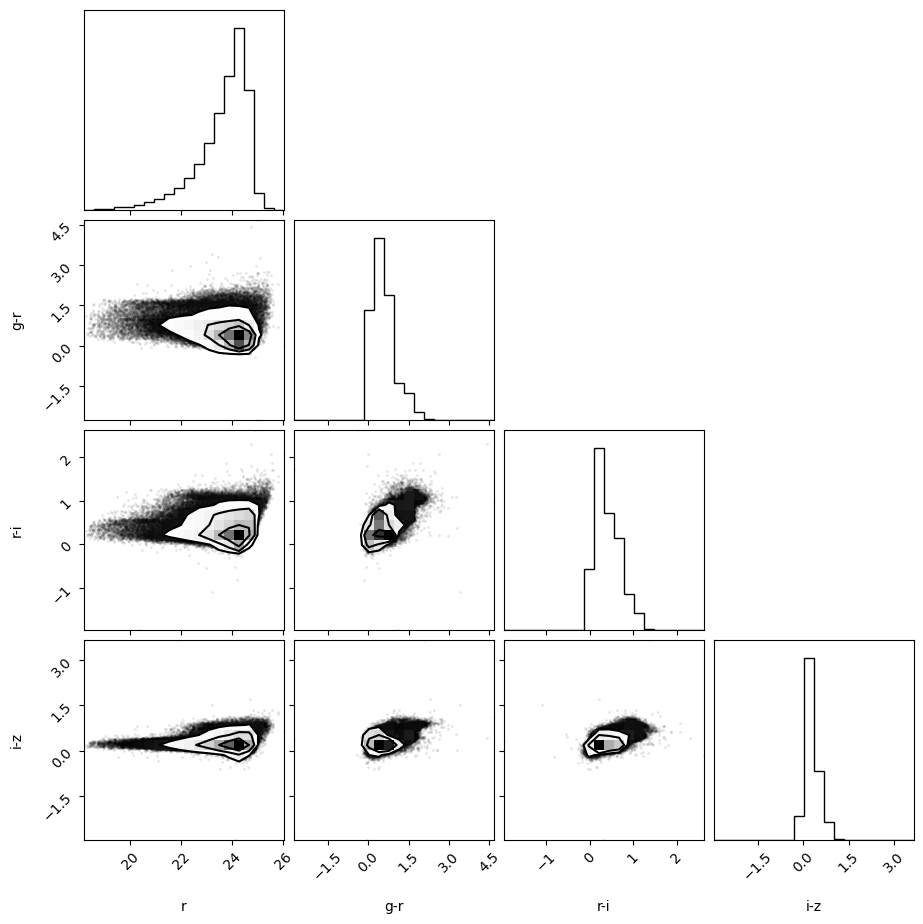

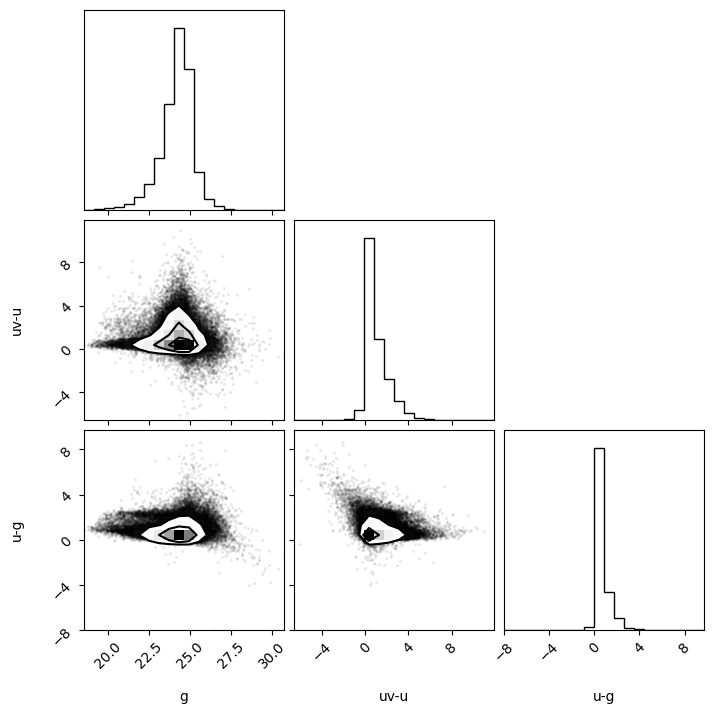

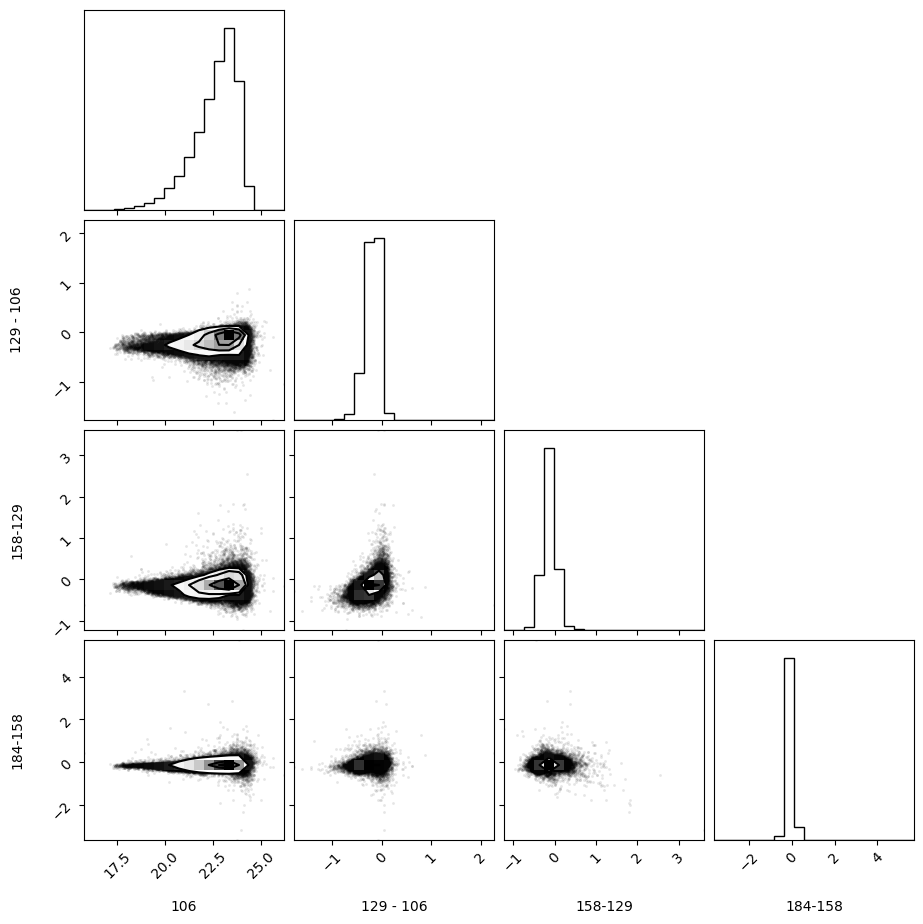

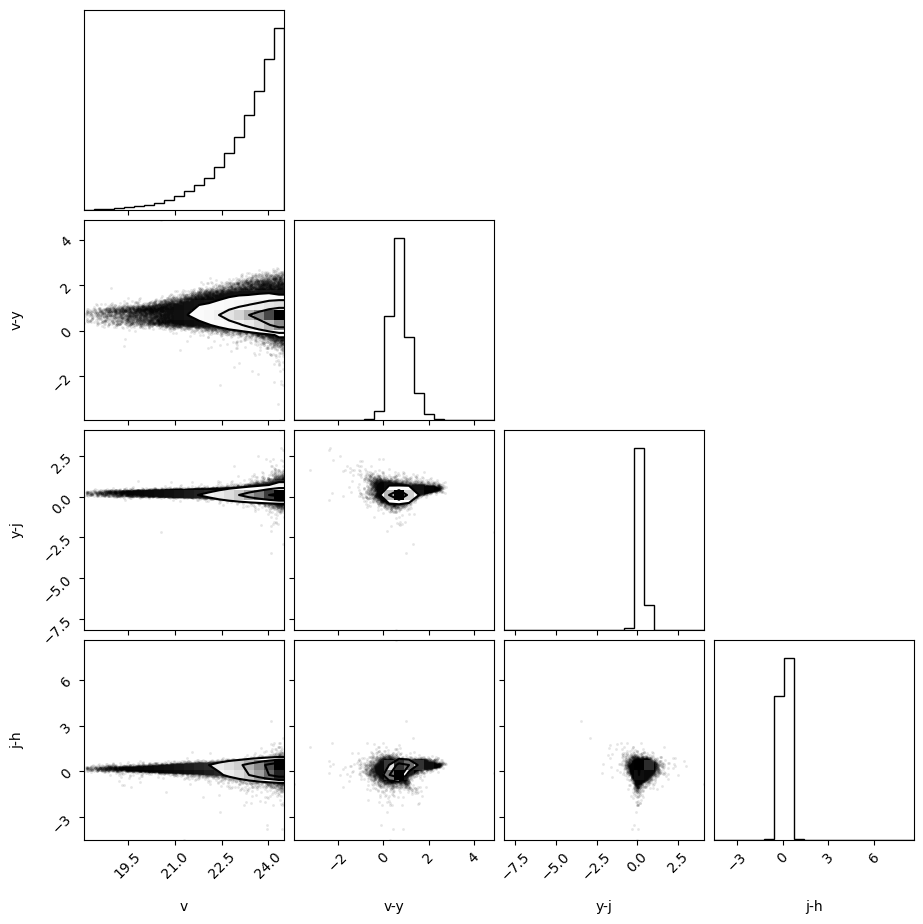

In [115]:
bad_masks = {}
for surv in which_cols.keys():
  bad_masks[surv] = {}
  fig = corner.corner(which_cols[surv])
  fig.show()
  for combo in which_cols[surv].keys():
    # print(which_cols[surv][combo])
    bad_masks[surv][combo] = np.isclose(np.array(which_cols[surv][combo]), np.zeros_like(which_cols[surv][combo]), atol=1e-3)

In [114]:
for surv in bad_masks.keys():
  for combo in bad_masks[surv].keys():
    print(surv, combo, sum(bad_masks[surv][combo]))

LSST r 0
LSST g-r 69
LSST r-i 100
LSST i-z 185
CASTOR g 0
CASTOR uv-u 44
CASTOR u-g 63
Roman 106 0
Roman 129 - 106 182
Roman 158-129 504
Roman 184-158 651
Euclid v 0
Euclid v-y 29
Euclid y-j 189
Euclid j-h 427


Close values seem to be drawing from the fact that the color distributions actually do cross zero, possibly associated with galaxies that have a break - at some redshifts the bands at that redshift are probing very flat regions of the SED, which is picked out as a feature learned by TLM - let's pick some from the 0 color spikes --> and highlight these in the uv-u color space

want to plot the different populations - color by redshift in the scatter plot --> show that these are different groups of SEDs and compare/contrast

representative SEDs from the clusters

Most improved and what got worse --> dimensionality and noise dimensions?

In [13]:
test_catalogs = {}
test_catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
# test_catalogs['Euclid+Roman'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
# test_catalogs['Roman+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
# test_catalogs['Roman+Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
# test_catalogs['Roman+Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()

catalogs = test_catalogs
